In [1]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

# from src.cache import cache

set_matplotlib_formats("svg")

In [2]:
df = pd.read_csv("../../data/daily_data.csv", parse_dates=["date"])
df.shape

(15344, 41)

In [3]:
df["size_radical"] = np.log(df["size_radical"] + 1)
df["size_moderate"] = np.log(df["size_moderate"] + 1)

In [4]:
# add exponential rolling averages for columns 'size_radical', 'size_moderate', 'count_radical', 'count_moderate'
df = df.groupby("region").apply(
    lambda x: x.sort_values("date").assign(
        size_radical_ewm_month=lambda x: x["size_radical"].ewm(span=35).mean(),
        size_moderate_ewm_month=lambda x: x["size_moderate"].ewm(span=35).mean(),
        count_radical_ewm_month=lambda x: x["count_radical"].ewm(span=35).mean(),
        count_moderate_ewm_month=lambda x: x["count_moderate"].ewm(span=35).mean(),
        size_radical_ewm_year=lambda x: x["size_radical"].ewm(span=380).mean(),
        size_moderate_ewm_year=lambda x: x["size_moderate"].ewm(span=380).mean(),
        count_radical_ewm_year=lambda x: x["count_radical"].ewm(span=380).mean(),
        count_moderate_ewm_year=lambda x: x["count_moderate"].ewm(span=380).mean(),
    )
)

/tmp/ipykernel_10051/2579751802.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby("region").apply(


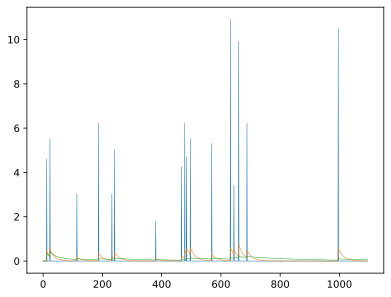

In [5]:
berlin = df.query("region == 'Berlin'").reset_index(drop=True)
plt.plot(berlin["size_moderate"], linewidth=0.5)
plt.plot(berlin["size_moderate_ewm_month"], linewidth=0.5)
plt.plot(berlin["size_moderate_ewm_year"], linewidth=0.5)
plt.show()

In [6]:
df = df.rename(
    columns={
        "region": "unique_id",
        "date": "ds",
    }
)
df.head()

,ds,unique_id,size_radical,size_moderate,count_radical,count_moderate,climate_and_protest_mediacloud,climate_not_protest_mediacloud,climate_mediacloud,instr_prcp,...,count_moderate_official,count_radical_official,size_radical_ewm_month,size_moderate_ewm_month,count_radical_ewm_month,count_moderate_ewm_month,size_radical_ewm_year,size_moderate_ewm_year,count_radical_ewm_year,count_moderate_ewm_year
0,2020-01-01,Nordrhein-Westfalen,0.0,0.0,0.0,0.0,10,42,52,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-01,Hamburg,0.0,0.0,0.0,0.0,5,9,14,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-01,Hessen,0.0,0.0,0.0,0.0,18,58,76,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-01,Bayern,0.0,0.0,0.0,0.0,1,21,22,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-01,Niedersachsen,0.0,0.0,0.0,0.0,4,24,28,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df["w"] = (df["count_moderate"] > 0) | (df["count_radical"] > 0)
df["w"].value_counts()

False    14969
True       375
Name: w, dtype: int64

In [8]:
df["y"] = df["w"].astype(int)
df = df.drop(columns=["w"])

In [9]:
df = pd.concat([df, pd.get_dummies(df["weekday"])], axis=1)
df = df.drop(columns=["weekday"])

In [10]:
df.columns

Index(['ds', 'unique_id', 'size_radical', 'size_moderate', 'count_radical',
       'count_moderate', 'climate_and_protest_mediacloud',
       'climate_not_protest_mediacloud', 'climate_mediacloud', 'instr_prcp',
       'instr_pres', 'instr_snow', 'instr_tavg', 'instr_tmax', 'instr_tmin',
       'instr_tsun', 'instr_wdir', 'instr_wpgt', 'instr_wspd',
       'instr_longterm_prcp', 'instr_longterm_pres', 'instr_longterm_snow',
       'instr_longterm_tavg', 'instr_longterm_tmax', 'instr_longterm_tmin',
       'instr_longterm_tsun', 'instr_longterm_wdir', 'instr_longterm_wpgt',
       'instr_longterm_wspd', 'instr_retail_and_recreation',
       'instr_grocery_and_pharmacy', 'instr_residential',
       'instr_transit_stations', 'instr_parks', 'instr_workplaces',
       'is_holiday', 'size_moderate_official', 'size_radical_official',
       'count_moderate_official', 'count_radical_official',
       'size_radical_ewm_month', 'size_moderate_ewm_month',
       'count_radical_ewm_month', 'count_

In [11]:
unique_ids = df["unique_id"].drop_duplicates().sort_values().reset_index(drop=True)
region_dummies = pd.get_dummies(unique_ids).astype(int)
static_df = pd.concat([unique_ids, region_dummies], axis=1)
static_df

,unique_id,Bayern,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Niedersachsen,Nordrhein-Westfalen,Rheinland-Pfalz,Saarland,Sachsen,Sachsen-Anhalt,Schleswig-Holstein,Thüringen
0,Bayern,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Berlin,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Brandenburg,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Bremen,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Hamburg,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,Hessen,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,Niedersachsen,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,Nordrhein-Westfalen,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,Rheinland-Pfalz,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,Saarland,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [12]:
hist_exog = [
    "size_radical",
    "size_moderate",
    "count_radical",
    "count_moderate",
    "climate_and_protest_mediacloud",
    "climate_not_protest_mediacloud",
    "climate_mediacloud",
    "size_radical_ewm_month",
    "size_moderate_ewm_month",
    "count_radical_ewm_month",
    "count_moderate_ewm_month",
    "size_radical_ewm_year",
    "size_moderate_ewm_year",
    "count_radical_ewm_year",
    "count_moderate_ewm_year",
]
futr_exog = [
    "is_holiday",
    "Friday",
    "Monday",
    "Saturday",
    "Sunday",
    "Thursday",
    "Tuesday",
    "Wednesday",
]
stat_exog = static_df.columns[1:].tolist()

In [13]:
split_date = pd.to_datetime("2021-12-31")

df = df[["ds", "unique_id", "y"] + hist_exog + futr_exog]
train_df = df[df.ds < split_date]
test_df = df[df.ds >= split_date]

In [14]:
from statsforecast import StatsForecast
from statsforecast.models import (  # SeasonalNaive: A model that uses the previous season's data as the forecast; Naive: A simple model that uses the last observed value as the forecast; HistoricAverage: This model uses the average of all historical data as the forecast; CrostonOptimized: A model specifically designed for intermittent demand forecasting; ADIDA: Adaptive combination of Intermittent Demand Approaches, a model designed for intermittent demand; IMAPA: Intermittent Multiplicative AutoRegressive Average, a model for intermittent series that incorporates autocorrelation; AutoETS: Automated Exponential Smoothing model that automatically selects the best Exponential Smoothing model based on AIC
    ADIDA,
    IMAPA,
    AutoETS,
    CrostonOptimized,
    HistoricAverage,
    Naive,
    SeasonalNaive,
)

horizon = 1

models = [
    HistoricAverage(),
    Naive(),
    SeasonalNaive(season_length=7),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    # AutoETS(season_length=7)
]

sf = StatsForecast(
    models=models,
    freq="D",
    n_jobs=-1,
)

/opt/conda/lib/python3.10/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [15]:
pred = sf.cross_validation(
    df=df, h=1, step_size=1, n_windows=int(2.5 * 365), refit=True
)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

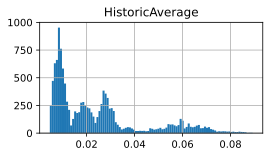

HistoricAverage
[[12464     0]
 [  304     0]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     12464
         1.0       0.00      0.00      0.00       304

    accuracy                           0.98     12768
   macro avg       0.49      0.50      0.49     12768
weighted avg       0.95      0.98      0.96     12768

AUC: 0.695


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Top F1: 0.109



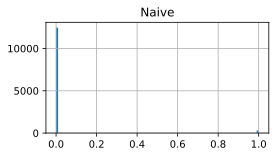

Naive
[[12188   276]
 [  273    31]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     12464
         1.0       0.10      0.10      0.10       304

    accuracy                           0.96     12768
   macro avg       0.54      0.54      0.54     12768
weighted avg       0.96      0.96      0.96     12768

AUC: 0.540
Top F1: 0.101



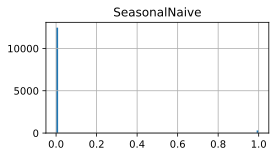

SeasonalNaive
[[12199   265]
 [  259    45]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     12464
         1.0       0.15      0.15      0.15       304

    accuracy                           0.96     12768
   macro avg       0.56      0.56      0.56     12768
weighted avg       0.96      0.96      0.96     12768

AUC: 0.563
Top F1: 0.147



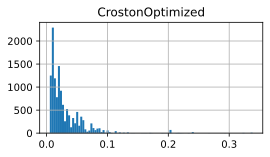

CrostonOptimized
[[12464     0]
 [  304     0]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     12464
         1.0       0.00      0.00      0.00       304

    accuracy                           0.98     12768
   macro avg       0.49      0.50      0.49     12768
weighted avg       0.95      0.98      0.96     12768

AUC: 0.698


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Top F1: 0.127



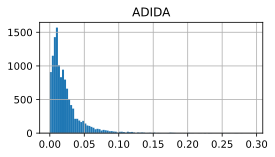

ADIDA
[[12464     0]
 [  304     0]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     12464
         1.0       0.00      0.00      0.00       304

    accuracy                           0.98     12768
   macro avg       0.49      0.50      0.49     12768
weighted avg       0.95      0.98      0.96     12768

AUC: 0.691


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Top F1: 0.135



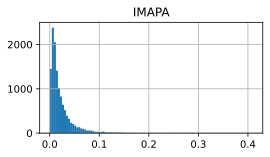

IMAPA
[[12464     0]
 [  304     0]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     12464
         1.0       0.00      0.00      0.00       304

    accuracy                           0.98     12768
   macro avg       0.49      0.50      0.49     12768
weighted avg       0.95      0.98      0.96     12768

AUC: 0.684


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Top F1: 0.155



In [16]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)

for model in models:
    pred[model.alias].hist(bins=100, figsize=(4, 2))
    plt.title(model.alias)
    plt.show()
    print(model.alias)
    y_true = pred["y"].values
    y_pred = (pred[model.alias] > 0.5).values
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    auc = roc_auc_score(y_true, pred[model.alias])
    print(f"AUC: {auc:.3f}")

    f1s = []
    for t in np.arange(0, 1, 0.01):
        y_pred = (pred[model.alias] > t).values
        f1 = f1_score(y_true, y_pred)
        f1s.append(f1)
    top_f1 = np.max(f1s)
    print(f"Top F1: {top_f1:.3f}")
    print()

In [70]:
region_dummies = pd.get_dummies(df["unique_id"]).astype(int)
ml_df = pd.concat([df, region_dummies], axis=1)
# ml_df["ds_"] = ml_df["ds"].dt.strftime("%Y-%m-%d")
ml_df.head()

,ds,unique_id,y,size_radical,size_moderate,count_radical,count_moderate,climate_and_protest_mediacloud,climate_not_protest_mediacloud,climate_mediacloud,...,Hamburg,Hessen,Niedersachsen,Nordrhein-Westfalen,Rheinland-Pfalz,Saarland,Sachsen,Sachsen-Anhalt,Schleswig-Holstein,Thüringen
0,2020-01-01,Nordrhein-Westfalen,0,0.0,0.0,0.0,0.0,10,42,52,...,0,0,0,1,0,0,0,0,0,0
1,2020-01-01,Hamburg,0,0.0,0.0,0.0,0.0,5,9,14,...,1,0,0,0,0,0,0,0,0,0
2,2020-01-01,Hessen,0,0.0,0.0,0.0,0.0,18,58,76,...,0,1,0,0,0,0,0,0,0,0
3,2020-01-01,Bayern,0,0.0,0.0,0.0,0.0,1,21,22,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-01,Niedersachsen,0,0.0,0.0,0.0,0.0,4,24,28,...,0,0,1,0,0,0,0,0,0,0


In [71]:
import lightgbm as lgb
from mlforecast import MLForecast
from sklearn.linear_model import LogisticRegression

standardized_df = df.copy()
standardized_df[hist_exog] = (
    standardized_df[hist_exog] - standardized_df[hist_exog].mean()
) / standardized_df[hist_exog].std()
standardized_df[futr_exog] = (
    standardized_df[futr_exog] - standardized_df[futr_exog].mean()
) / standardized_df[futr_exog].std()

from sklearn.base import BaseEstimator


class TestModel(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        print(X.shape, y.shape)
        print(X.columns)
        print(X["ds_"].min(), X["ds_"].max())
        # raise Exception("Test")
        return self

    def predict(self, X):
        print(X.shape)
        print(X.columns)
        print(X["ds_"].min(), X["ds_"].max())
        raise Exception("Test")
        # always return 1
        return np.ones(X.shape[0])

    def predict_proba(self, X):
        # always return 1
        return np.ones((X.shape[0], 2))

    def predict_log_proba(self, X):
        # always return 1
        return np.ones((X.shape[0], 2))


models = [
    # TestModel(),
    LogisticRegression(
        class_weight="balanced", max_iter=1000, n_jobs=-1
    )  # penalty="elasticnet",
]

mlf = MLForecast(
    models=models,
    # lags=[1,2,3,7,14],
    freq="D",
)

In [72]:
pred = mlf.cross_validation(
    data=ml_df,
    step_size=1,
    n_windows=int(2.5 * 365),
    window_size=1,
    input_size=3 * 28,
    refit=True,
    static_features=region_dummies.columns,
)

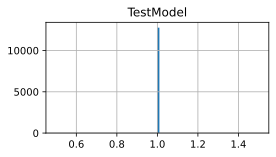

TestModel
[[    0 12464]
 [    0   304]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12464
           1       0.02      1.00      0.05       304

    accuracy                           0.02     12768
   macro avg       0.01      0.50      0.02     12768
weighted avg       0.00      0.02      0.00     12768

AUC: 0.500


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Top F1: 0.047



In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)

for model in models:
    name = model.__class__.__name__
    pred[name].hist(bins=100, figsize=(4, 2))
    plt.title(name)
    plt.show()
    print(name)
    y_true = pred["y"].values
    y_pred = (pred[name] > 0.5).values
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    auc = roc_auc_score(y_true, pred[name])
    print(f"AUC: {auc:.3f}")

    f1s = []
    for t in np.arange(0, 1, 0.01):
        y_pred = (pred[name] > t).values
        f1 = f1_score(y_true, y_pred)
        f1s.append(f1)
    top_f1 = np.max(f1s)
    print(f"Top F1: {top_f1:.3f}")
    print()

In [ ]:
from typing import Union

import torch
import torch.nn as nn
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MAE, MSE, Accuracy, DistributionLoss
from neuralforecast.models import LSTM, MLP, NBEATS, NHITS, NBEATSx


class WeightedCrossEntropyLoss(nn.Module):
    """
    Weighted Cross-Entropy Loss

    Calculates the weighted cross-entropy loss between
    true labels `y` and predicted probabilities `y_hat`.
    This loss function is used for binary classification problems
    and is suitable when there is class imbalance.

    $$ \\mathrm{WeightedCrossEntropyLoss}(\\mathbf{y}, \\mathbf{y\\_hat}, \\mathbf{pos\\_weight}, \\mathbf{neg\\_weight})
    = - \\frac{1}{N} \\sum_{i=1}^{N} [pos\\_weight * y_{i} * \\log(y\\_hat_{i}) + neg\\_weight * (1 - y_{i}) * \\log(1 - y\\_hat_{i})] $$
    """

    def __init__(self, pos_weight: float, neg_weight: float):
        super().__init__()
        self.pos_weight = pos_weight
        self.neg_weight = neg_weight
        self.outputsize_multiplier = 1
        self.output_names = [""]
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        No idea what this is for.
        """
        return y_hat.squeeze(-1)

    def forward(
        self,
        y: torch.Tensor,
        y_hat: torch.Tensor,
        mask: Union[torch.Tensor, None] = None,
    ):
        """
        **Parameters:**<br>
        `y`: tensor, Actual binary labels.<br>
        `y_hat`: tensor, Predicted probabilities.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `loss`: tensor (single value).
        """
        if mask is None:
            mask = torch.ones_like(y)

        loss = -self.pos_weight * y * torch.log(y_hat) - self.neg_weight * (
            1 - y
        ) * torch.log(1 - y_hat)
        loss = loss * mask
        loss = torch.mean(loss)
        return loss

In [ ]:
class F1ScoreLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.outputsize_multiplier = 1
        self.output_names = [""]
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        No idea what this is for.
        """
        return y_hat.squeeze(-1)

    def forward(
        self,
        y: torch.Tensor,
        y_hat: torch.Tensor,
        mask: Union[torch.Tensor, None] = None,
    ):
        """
        **Parameters:**<br>
        `y`: tensor, Actual binary labels.<br>
        `y_hat`: tensor, Predicted probabilities.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `loss`: tensor (single value).
        """
        if mask is None:
            mask = torch.ones_like(y)

        recall = torch.sum(y * y_hat) / torch.sum(y)
        precision = torch.sum(y * y_hat) / torch.sum(y_hat)
        loss = 2 * (precision * recall) / (precision + recall)
        loss = loss * mask
        loss = torch.mean(loss)
        return loss

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MAE, MSE, Accuracy, DistributionLoss
from neuralforecast.models import LSTM, MLP, NBEATS, NHITS, NBEATSx

# from torch.nn.modules.loss import CrossEntropyLoss

horizon = 1

pos_weight = len(df["y"]) / (2 * df["y"].sum())
neg_weight = len(df["y"]) / (2 * (len(df["y"]) - df["y"].sum()))
print(f"pos_weight: {pos_weight}")
print(f"neg_weight: {neg_weight}")

models = [
    NHITS(
        h=horizon,  # Forecast horizon
        input_size=6 * 28,  # Length of input sequence
        loss=DistributionLoss("Bernoulli"),  # Binary classification loss
        # loss=WeightedCrossEntropyLoss(pos_weight, neg_weight),
        # valid_loss=Accuracy(),  # Accuracy validation signal
        valid_loss=F1ScoreLoss(),
        max_steps=500,  # Number of steps to train
        n_freq_downsample=[2, 1, 1],  # Downsampling factors for each stack output
        # early_stop_patience_steps=2,        # Early stopping regularization patience
        # val_check_steps=10,  # Frequency of validation signal (affects early stopping)
        hist_exog_list=hist_exog,
        futr_exog_list=futr_exog,
        stat_exog_list=stat_exog,
        scaler_type="robust",
    ),
]
nf = NeuralForecast(models=models, freq="D")

Global seed set to 1


pos_weight: 20.458666666666666
neg_weight: 0.5125258868327878


In [ ]:
# %%capture

# nf.fit(df=train_df, static_df=static_df)

In [ ]:
# Y_pred = nf.predict(df=train_df, static_df=static_df, futr_df=test_df)
# Y_pred

In [ ]:
%%capture

pred = nf.cross_validation(
    df=df, static_df=static_df, step_size=1, n_windows=int(2.5 * 365)
)

In [ ]:
pred

,unique_id,ds,cutoff,NHITS,NHITS-median,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,y,...,count_radical_ewm,count_moderate_ewm,is_holiday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Bayern,2020-07-03,2020-07-02,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0.0,2.391302e-01,False,1,0,0,0,0,0,0
1,Bayern,2020-07-04,2020-07-03,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0.0,2.916040e-01,False,0,0,1,0,0,0,0
2,Bayern,2020-07-05,2020-07-04,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,2.714934e-01,False,0,0,0,1,0,0,0
3,Bayern,2020-07-06,2020-07-05,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,2.527697e-01,False,0,1,0,0,0,0,0
4,Bayern,2020-07-07,2020-07-06,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,2.353372e-01,False,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12763,Thüringen,2022-12-27,2022-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,1.316827e-14,False,0,0,0,0,0,1,0
12764,Thüringen,2022-12-28,2022-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,1.226011e-14,False,0,0,0,0,0,0,1
12765,Thüringen,2022-12-29,2022-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,1.141459e-14,False,0,0,0,0,1,0,0
12766,Thüringen,2022-12-30,2022-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,1.062737e-14,False,1,0,0,0,0,0,0


<Axes: >

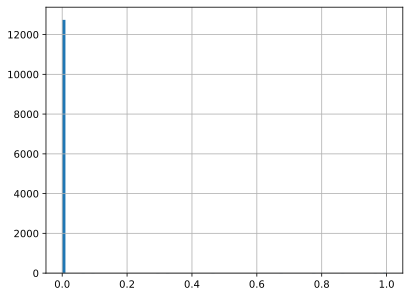

In [ ]:
pred["NHITS"].hist(bins=100)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels and predicted labels
y_true = pred["y"].values
y_pred = (pred["NHITS"] > 0.5).values

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate the classification report
report = classification_report(y_true, y_pred)

# Print the confusion matrix, recall, precision, and F1-score
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[12443    21]
 [  304     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     12464
           1       0.00      0.00      0.00       304

    accuracy                           0.97     12768
   macro avg       0.49      0.50      0.49     12768
weighted avg       0.95      0.97      0.96     12768



In [ ]:
pred["NHITS"].value_counts()

0.000    12735
1.000       11
0.003        2
0.004        2
0.679        1
0.994        1
0.866        1
0.988        1
0.001        1
0.962        1
0.462        1
0.775        1
0.094        1
0.998        1
0.996        1
0.324        1
0.299        1
0.010        1
0.063        1
0.986        1
0.013        1
0.963        1
Name: NHITS, dtype: int64

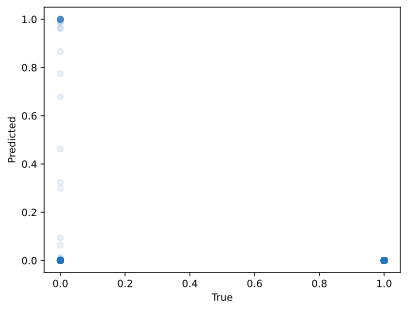

In [ ]:
plt.scatter(pred["y"], pred["NHITS"], alpha=0.1)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot()